In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv('metrike/triton_rezultati.csv')
df

,test,model,batch_size,floating_point,concurrency,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,request/response,response wait
0,alpha,gemma3,1,fp16,1:24:2,0,1,0.643508,50,719,...,17,1550278,39,0,1542649,1545638,1546397,1561484,50,1551326
1,alpha,gemma3,2,fp16,1:24:2,0,19,1.185160,54,819,...,66,6588780,81,0,32932954,32973698,32975293,34715581,54,30954911
2,alpha,gemma3,2,fp16,1:24:2,0,11,1.203680,48,752,...,41,6208113,74,0,18114342,18157300,19758219,19796982,48,18116455
3,alpha,gemma3,2,fp16,1:24:2,0,5,1.203680,51,815,...,34,5601306,73,0,8238339,8254527,8257616,8259402,51,8238383
4,alpha,gemma3,2,fp16,1:24:2,0,9,1.203680,54,820,...,33,5777241,83,0,14816465,16490745,16580923,18095577,54,14707821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,kappa,rt-meta-llama,8,f32,1:128:16,0,49,3754.660000,86,4705,...,25,11155,3780,82483,81683,228828,234515,244643,82569,17868
445,kappa,rt-meta-llama,8,f32,1:128:16,0,65,3838.240000,139,3336,...,25,11742,3709,112443,110915,271311,295479,307773,112582,20705
446,kappa,rt-meta-llama,8,f32,1:128:16,0,97,3867.420000,244,5185,...,26,12111,3734,167486,198150,348528,357235,383731,167730,29346
447,kappa,rt-meta-llama,8,f32,1:128:16,0,81,3922.710000,216,4862,...,24,12203,3737,129274,144325,313809,328600,340716,129490,32031


In [2]:
### concatenate test, batch_size, floating_point, kv_cache in one column
df['test'] = (df['test'].astype(str) + '_b' + df['batch_size'].astype(str) + '_' + df['floating_point'].astype(str) +
              '_kv' + df['kv_cache'].astype(str))
df.head()

,test,model,batch_size,floating_point,concurrency,kv_cache,Concurrency,Inferences/Second,Client Send,Network+Server Send/Recv,...,Server Compute Input,Server Compute Infer,Server Compute Output,Client Recv,p50 latency,p90 latency,p95 latency,p99 latency,request/response,response wait
0,alpha_b1_fp16_kv0,gemma3,1,fp16,1:24:2,0,1,0.643508,50,719,...,17,1550278,39,0,1542649,1545638,1546397,1561484,50,1551326
1,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,19,1.185160,54,819,...,66,6588780,81,0,32932954,32973698,32975293,34715581,54,30954911
2,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,11,1.203680,48,752,...,41,6208113,74,0,18114342,18157300,19758219,19796982,48,18116455
3,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,5,1.203680,51,815,...,34,5601306,73,0,8238339,8254527,8257616,8259402,51,8238383
4,alpha_b2_fp16_kv0,gemma3,2,fp16,1:24:2,0,9,1.203680,54,820,...,33,5777241,83,0,14816465,16490745,16580923,18095577,54,14707821


In [3]:
#Zadrži samo relevantne kolone\n",
df_filtered = df[
 ['test', 'model', 'batch_size', 'floating_point', 'kv_cache',
  'Concurrency', 'Inferences/Second',
'p50 latency', 'p90 latency', 'p95 latency', 'p99 latency', 'response wait']].copy()

# convert latency columns to seconds from microseconds
df_filtered['p50 latency'] = round(df_filtered['p50 latency'] / 1000000, 3)
df_filtered['p90 latency'] = round(df_filtered['p90 latency'] / 1000000, 3)
df_filtered['p95 latency'] = round(df_filtered['p95 latency'] / 1000000, 3)
df_filtered['p99 latency'] = round(df_filtered['p99 latency'] / 1000000, 3)

In [4]:
# Add a combined metric
df_filtered['throughput_latency_ratio'] = df_filtered['Inferences/Second'] / df_filtered['p99 latency']
# For each test and model, get the row with the highest ratio
best_rows = df_filtered.loc[df_filtered.groupby(['test', 'model'])['throughput_latency_ratio'].idxmax()]

In [5]:
# order by highest throughput_latency_ratio
best_rows = best_rows.sort_values(by='throughput_latency_ratio', ascending=False)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(10)

,test,model,batch_size,floating_point,kv_cache,Concurrency,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,iota_b1_f32_kv8192,rt-mistral,1,f32,8192,113,5969.2200,0.019,0.022,0.022,0.023,16162,259531.304348
1,iota_b4_f32_kv8192,rt-mistral,4,f32,8192,17,4654.9900,0.014,0.017,0.018,0.020,11997,232749.500000
2,kappa_b8_f32_kv0,rt-mistral,8,f32,0,17,6109.4200,0.022,0.024,0.025,0.027,18963,226274.814815
3,iota_b8_f32_kv8192,rt-mistral,8,f32,8192,17,6115.9900,0.022,0.025,0.026,0.028,17683,218428.214286
4,theta_b8_f32_kv4096,rt-mistral,8,f32,4096,17,5347.0600,0.026,0.032,0.033,0.035,14652,152773.142857
5,iota_b4_f32_kv8192,rt-meta-llama,4,f32,8192,17,2906.7600,0.022,0.030,0.033,0.041,13833,70896.585366
6,iota_b1_f32_kv8192,rt-meta-llama,1,f32,8192,65,2654.5200,0.024,0.033,0.037,0.041,15414,64744.390244
7,kappa_b8_f32_kv0,rt-meta-llama,8,f32,0,17,2976.1300,0.033,0.080,0.084,0.091,14962,32704.725275
8,iota_b8_f32_kv8192,rt-meta-llama,8,f32,8192,1,346.1320,0.021,0.033,0.034,0.035,14150,9889.485714
9,iota_b1_f32_kv8192,rt-gemma3,1,f32,8192,1,13.4986,0.074,0.074,0.075,0.077,73426,175.306494


In [6]:
# remove Concurrency column
best_rows.drop(columns=['Concurrency'], inplace=True)
# Display the best rows
best_rows.reset_index(drop=True, inplace=True)
best_rows.head(20)

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,iota_b1_f32_kv8192,rt-mistral,1,f32,8192,5969.22000,0.019,0.022,0.022,0.023,16162,259531.304348
1,iota_b4_f32_kv8192,rt-mistral,4,f32,8192,4654.99000,0.014,0.017,0.018,0.020,11997,232749.500000
2,kappa_b8_f32_kv0,rt-mistral,8,f32,0,6109.42000,0.022,0.024,0.025,0.027,18963,226274.814815
3,iota_b8_f32_kv8192,rt-mistral,8,f32,8192,6115.99000,0.022,0.025,0.026,0.028,17683,218428.214286
4,theta_b8_f32_kv4096,rt-mistral,8,f32,4096,5347.06000,0.026,0.032,0.033,0.035,14652,152773.142857
5,iota_b4_f32_kv8192,rt-meta-llama,4,f32,8192,2906.76000,0.022,0.030,0.033,0.041,13833,70896.585366
6,iota_b1_f32_kv8192,rt-meta-llama,1,f32,8192,2654.52000,0.024,0.033,0.037,0.041,15414,64744.390244
7,kappa_b8_f32_kv0,rt-meta-llama,8,f32,0,2976.13000,0.033,0.080,0.084,0.091,14962,32704.725275
8,iota_b8_f32_kv8192,rt-meta-llama,8,f32,8192,346.13200,0.021,0.033,0.034,0.035,14150,9889.485714
9,iota_b1_f32_kv8192,rt-gemma3,1,f32,8192,13.49860,0.074,0.074,0.075,0.077,73426,175.306494


In [7]:
# from the best rows get the best for each model
best_per_model = best_rows.loc[best_rows.groupby('model')['throughput_latency_ratio'].idxmax()]
best_per_model = best_per_model.sort_values(by='throughput_latency_ratio', ascending=False)
# Reset index for better readability
best_per_model.reset_index(drop=True, inplace=True)
# Display the best rows
best_per_model.head(20)

# remove batch size. p50 latency, p90 latency, response wait
best_per_model = best_per_model.drop(columns=['p50 latency', 'p90 latency', 'p95 latency', 'response wait'])
# Display the best rows
best_per_model.reset_index(drop=True, inplace=True)
best_per_model

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p99 latency,throughput_latency_ratio
0,iota_b1_f32_kv8192,rt-mistral,1,f32,8192,5969.22000,0.023,259531.304348
1,iota_b4_f32_kv8192,rt-meta-llama,4,f32,8192,2906.76000,0.041,70896.585366
2,iota_b1_f32_kv8192,rt-gemma3,1,f32,8192,13.49860,0.077,175.306494
3,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,3.165,4.310205
4,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.749,2.618754
5,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.02461,5.139,1.756102


### Best configurations for rt-mistral


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
0,iota_b1_f32_kv8192,rt-mistral,1,f32,8192,5969.22,0.019,0.022,0.022,0.023,16162,259531.304348
1,iota_b4_f32_kv8192,rt-mistral,4,f32,8192,4654.99,0.014,0.017,0.018,0.020,11997,232749.500000
2,kappa_b8_f32_kv0,rt-mistral,8,f32,0,6109.42,0.022,0.024,0.025,0.027,18963,226274.814815
3,iota_b8_f32_kv8192,rt-mistral,8,f32,8192,6115.99,0.022,0.025,0.026,0.028,17683,218428.214286
4,theta_b8_f32_kv4096,rt-mistral,8,f32,4096,5347.06,0.026,0.032,0.033,0.035,14652,152773.142857




### Best configurations for rt-meta-llama


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
5,iota_b4_f32_kv8192,rt-meta-llama,4,f32,8192,2906.760,0.022,0.030,0.033,0.041,13833,70896.585366
6,iota_b1_f32_kv8192,rt-meta-llama,1,f32,8192,2654.520,0.024,0.033,0.037,0.041,15414,64744.390244
7,kappa_b8_f32_kv0,rt-meta-llama,8,f32,0,2976.130,0.033,0.080,0.084,0.091,14962,32704.725275
8,iota_b8_f32_kv8192,rt-meta-llama,8,f32,8192,346.132,0.021,0.033,0.034,0.035,14150,9889.485714




### Best configurations for rt-gemma3


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
9,iota_b1_f32_kv8192,rt-gemma3,1,f32,8192,13.4986,0.074,0.074,0.075,0.077,73426,175.306494
10,iota_b4_f32_kv8192,rt-gemma3,4,f32,8192,17.5532,0.227,0.228,0.228,0.228,223045,76.987719
11,iota_b8_f32_kv8192,rt-gemma3,8,f32,8192,18.6628,0.425,0.429,0.429,0.429,418648,43.503030
12,kappa_b8_f32_kv0,rt-gemma3,8,f32,0,18.7015,0.423,0.427,0.427,0.430,420231,43.491860
13,theta_b8_f32_kv4096,rt-gemma3,8,f32,4096,18.6639,0.424,0.427,0.427,0.431,418916,43.303712




### Best configurations for mistral


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
14,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205
21,gama_b8_bf16_kv128,mistral,8,bf16,128,14.39490,4.551,6.609,6.913,7.215,4989904,1.995135
22,eta_b8_f16_kv4096,mistral,8,f16,4096,14.61710,4.439,7.348,7.552,7.768,4918528,1.881707
24,eta_b8_f32_kv4096,mistral,8,f32,4096,14.72820,4.385,8.287,8.542,8.758,4870515,1.681685
26,alpha_b4_fp16_kv0,mistral,4,fp16,0,4.44434,2.690,2.782,2.817,2.843,2704351,1.563257
30,delta_b8_bf16_kv256,mistral,8,bf16,256,14.81470,8.725,11.128,11.457,11.879,9125883,1.247134
32,alpha_b2_fp16_kv0,mistral,2,fp16,0,3.56475,2.773,2.858,2.902,3.052,2786456,1.168005
33,epsilon_b8_bf16_kv4096,mistral,8,bf16,4096,3.13577,2.551,2.630,2.646,2.693,2549062,1.164415
39,beta_b1_bf16_kv0,mistral,1,bf16,0,1.81325,2.753,2.824,2.866,2.940,2760377,0.616752
40,alpha_b1_fp16_kv0,mistral,1,fp16,0,1.79163,2.757,2.825,2.875,3.082,2793968,0.581321




### Best configurations for gemma3


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
15,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.580200,1.741,1.746,1.747,1.749,1749885,2.618754
16,gama_b8_bf16_kv128,gemma3,8,bf16,128,4.555510,1.747,1.750,1.751,1.753,1756092,2.598694
17,eta_b8_bf16_kv4096,gemma3,8,bf16,4096,4.506120,1.768,1.771,1.773,1.776,1774836,2.537230
18,beta_b8_bf16_kv0,gemma3,8,bf16,0,4.493780,1.765,1.774,1.774,1.776,1775727,2.530282
19,delta_b8_bf16_kv256,gemma3,8,bf16,256,4.777730,1.671,1.674,1.675,2.197,1676417,2.174661
20,epsilon_b8_bf16_kv4096,gemma3,8,bf16,4096,4.716000,1.691,1.696,1.697,2.230,1695595,2.114798
27,eta_b8_f32_kv4096,gemma3,8,f32,4096,3.506140,2.271,2.273,2.274,2.276,2278472,1.540483
28,alpha_b4_fp16_kv0,gemma3,4,fp16,0,2.240690,1.780,1.784,1.787,1.791,2371328,1.251083
38,alpha_b2_fp16_kv0,gemma3,2,fp16,0,1.212930,1.644,1.648,1.649,1.652,1643779,0.734219
41,gama_b1_bf16_kv128,gemma3,1,bf16,128,0.651227,1.533,1.550,1.552,1.558,1535922,0.417989




### Best configurations for meta-llama


,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio
23,beta_b8_bf16_kv0,meta-llama,8,bf16,0,9.024610,4.403,4.839,4.929,5.139,4424416,1.756102
25,eta_b8_f16_kv4096,meta-llama,8,f16,4096,11.629400,6.204,6.672,6.882,7.171,6199950,1.621726
29,gama_b8_bf16_kv128,meta-llama,8,bf16,128,11.469000,5.831,8.414,8.868,9.172,6243350,1.250436
31,eta_b8_bf16_kv4096,meta-llama,8,bf16,4096,11.148000,6.164,8.679,9.010,9.388,6461775,1.187473
34,eta_b8_f32_kv4096,meta-llama,8,f32,4096,3.049350,2.624,2.661,2.663,2.671,2619559,1.141651
35,epsilon_b8_bf16_kv4096,meta-llama,8,bf16,4096,2.987620,2.688,2.740,2.746,2.756,2678517,1.084042
36,delta_b8_bf16_kv256,meta-llama,8,bf16,256,2.987620,2.672,2.730,2.750,2.788,2679090,1.071600
37,alpha_b4_fp16_kv0,meta-llama,4,fp16,0,5.277680,5.250,5.492,5.557,5.721,5244459,0.922510
45,alpha_b2_fp16_kv0,meta-llama,2,fp16,0,1.481450,4.059,4.570,4.770,4.887,4028366,0.303141
46,beta_b1_bf16_kv0,meta-llama,1,bf16,0,1.310170,3.815,4.136,4.230,4.391,3820431,0.298376


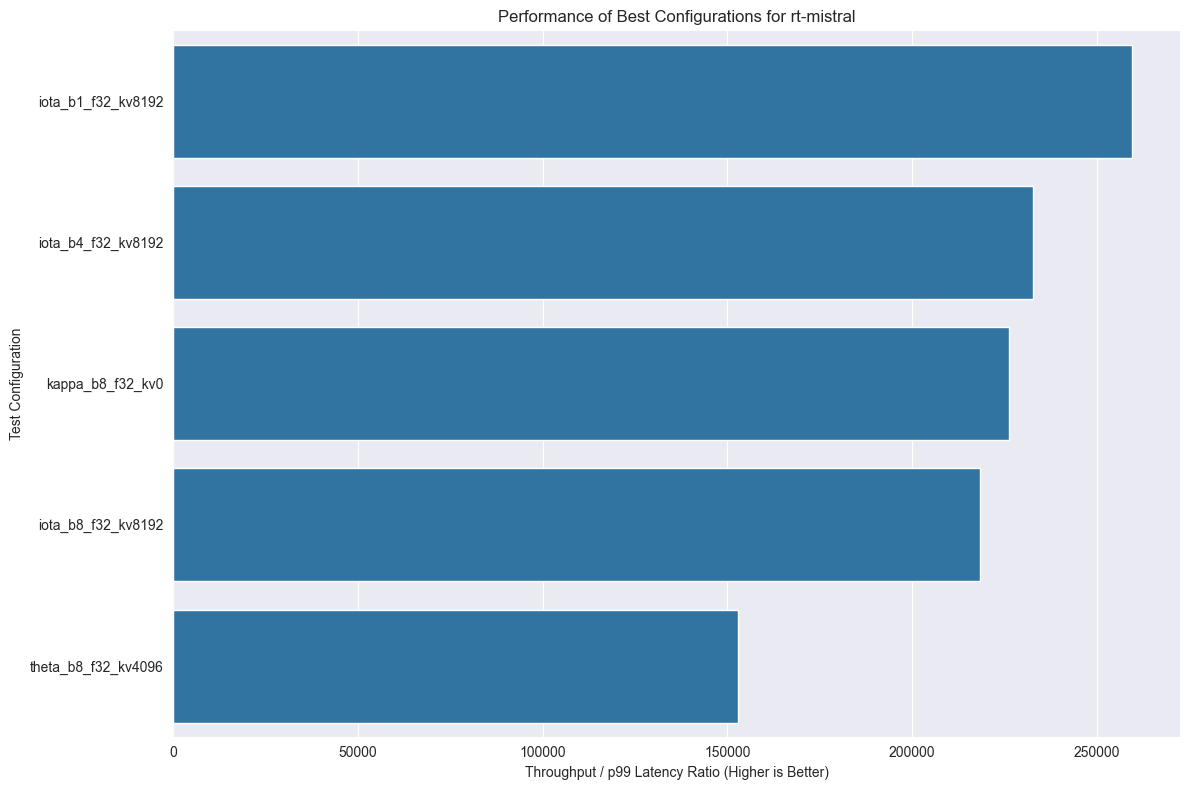

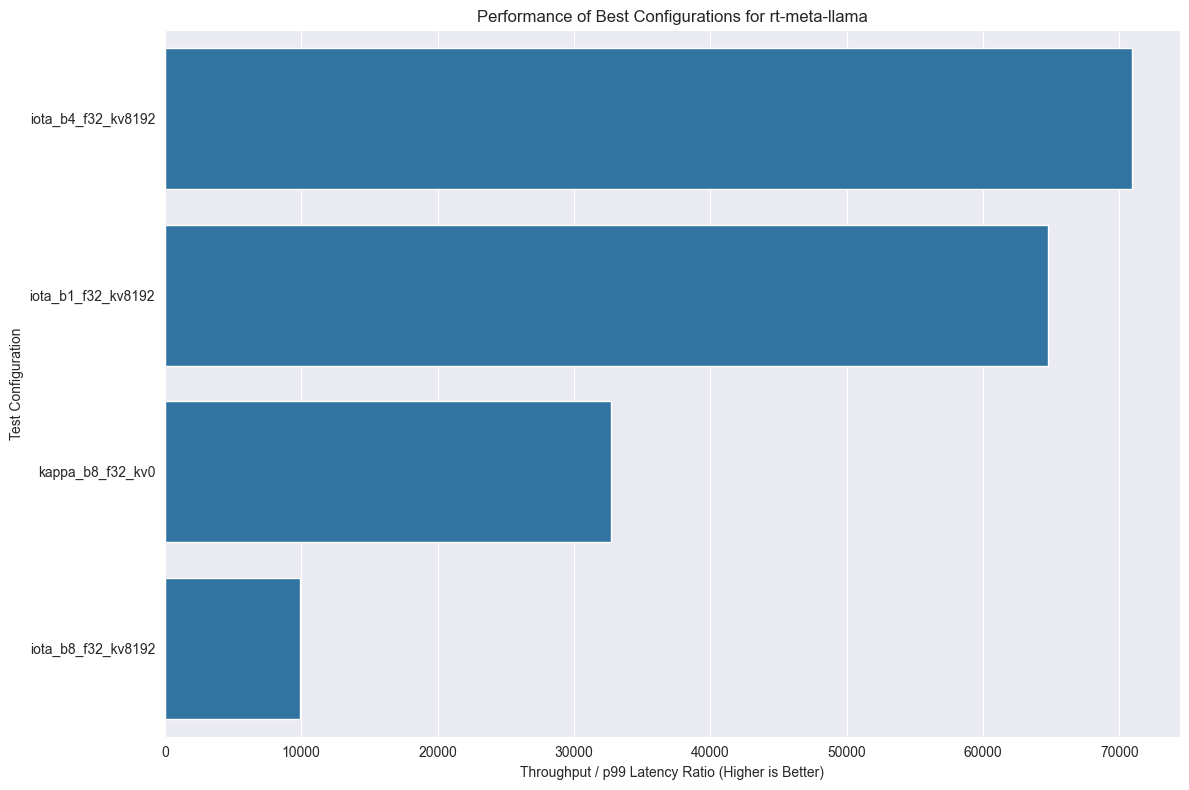

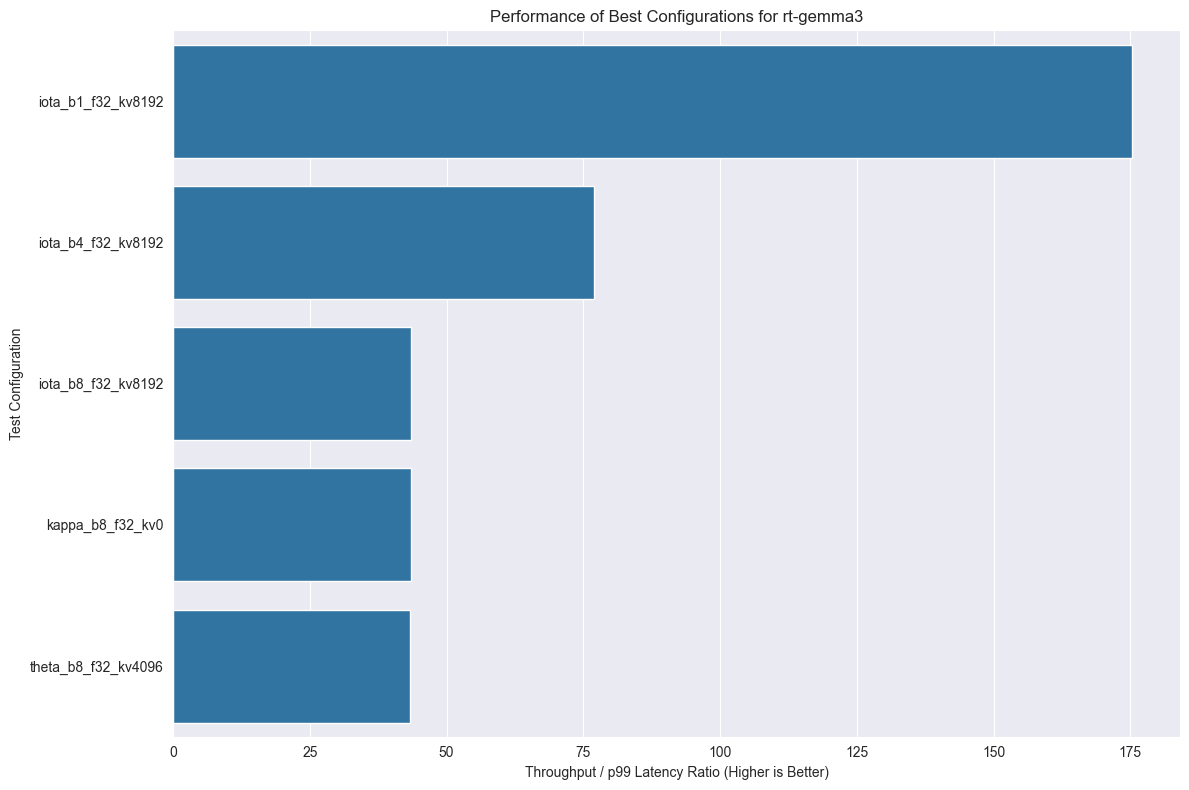

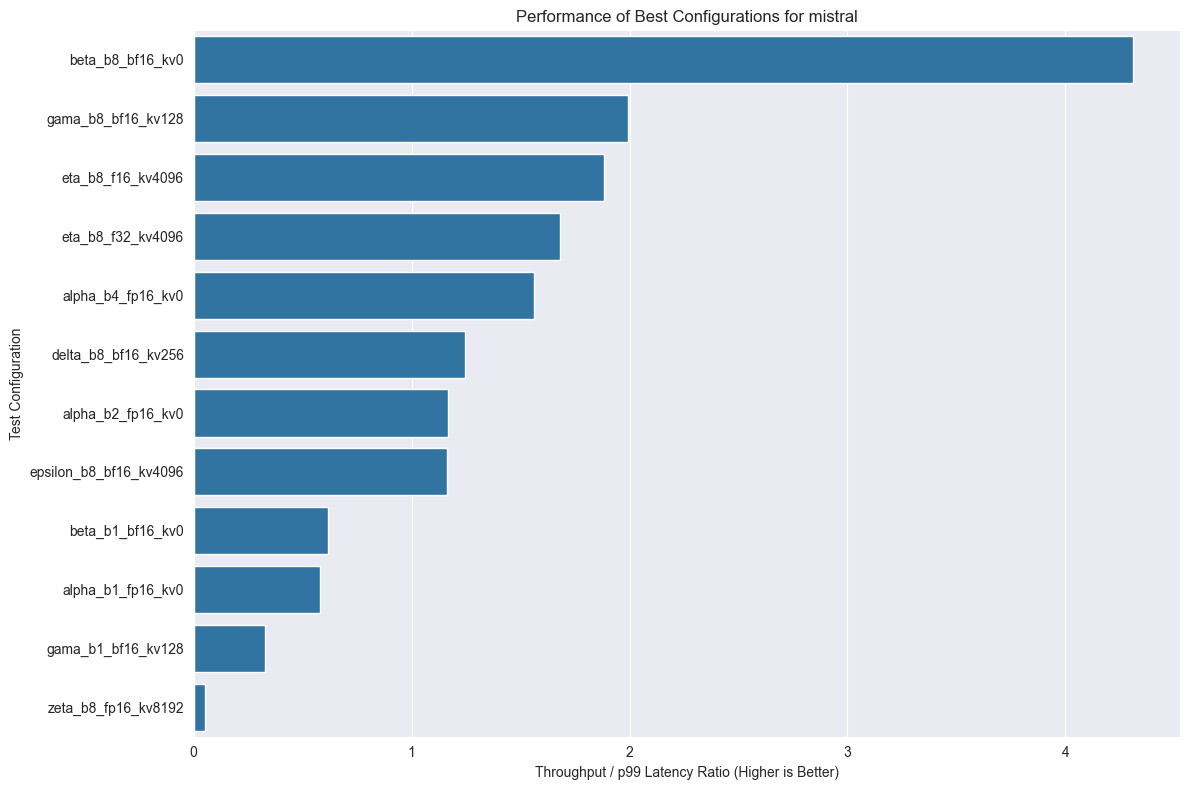

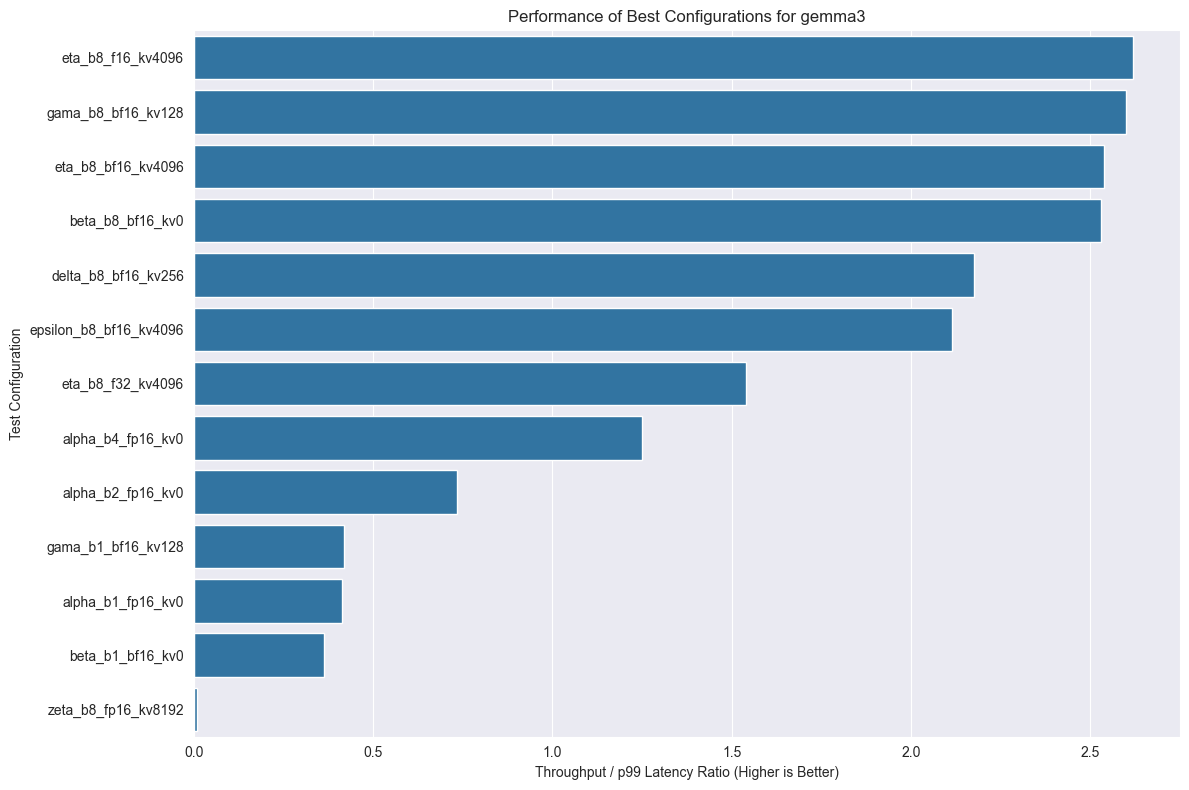

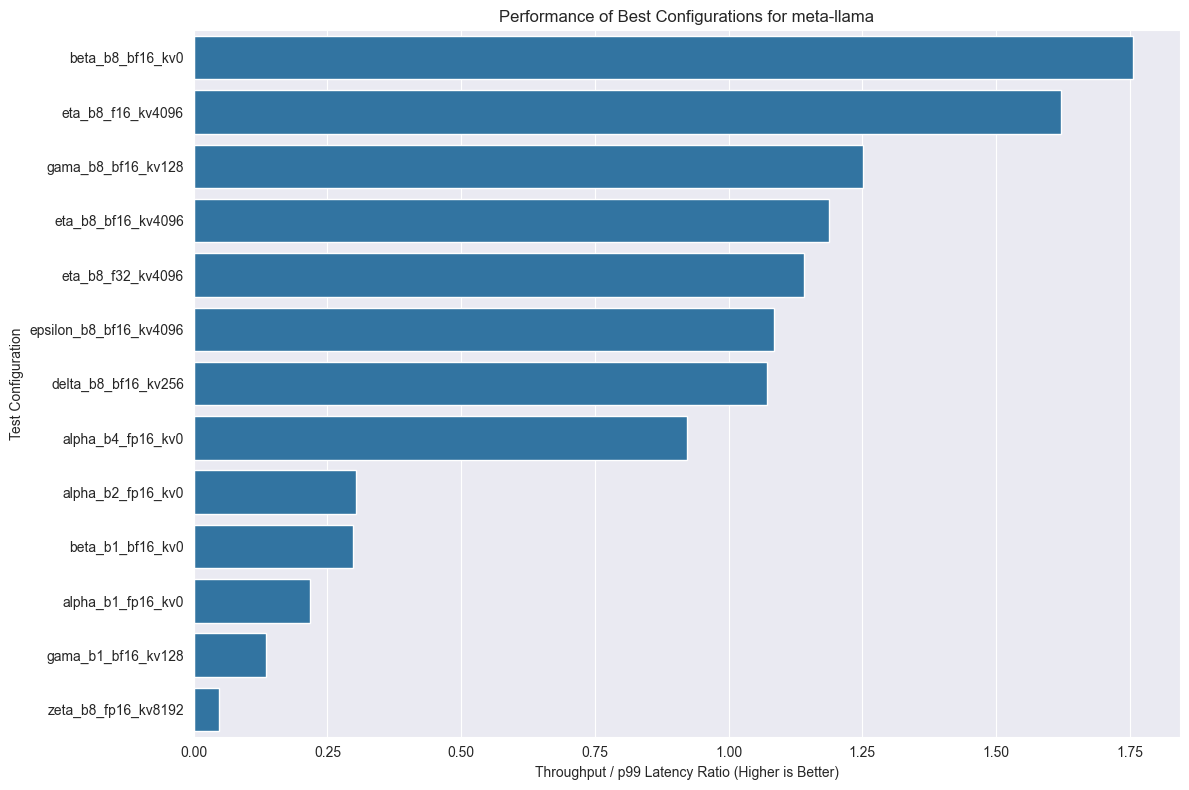

In [8]:
# Create a dictionary to hold the dataframes for each model
model_dfs = {}
unique_models = best_rows['model'].unique()

# Split the dataframe by model
for model in unique_models:
    # Sort by the ratio to have the best results on top for each model
    model_df = best_rows[best_rows['model'] == model].sort_values(by='throughput_latency_ratio', ascending=False)
    model_dfs[model] = model_df

# Display the table for each model
for model_name, df_model in model_dfs.items():
    print(f"### Best configurations for {model_name}")
    display(df_model)
    print("\n")

# Create and display visuals for each model
for model_name, df_model in model_dfs.items():
    plt.figure(figsize=(12, 8))
    sns.barplot(data=df_model, x='throughput_latency_ratio', y='test', orient='h')
    plt.title(f'Performance of Best Configurations for {model_name}')
    plt.xlabel('Throughput / p99 Latency Ratio (Higher is Better)')
    plt.ylabel('Test Configuration')
    plt.tight_layout()
    plt.show()

In [26]:
import pandas as pd

# Load the user perspective metrics
df1 = pd.read_csv('metrike/prompts/llm_stress_test_results.csv')
df2 = pd.read_csv('metrike/prompts/llm_chat_test_results.csv')
df3 = pd.read_csv('metrike/prompts/llm_summarize_test_results.csv')
df4 = pd.read_csv('metrike/prompts/llm_batch_test_results.csv')

df = pd.concat([df1, df2, df3, df4], ignore_index=True)

# Calculate average user metrics per model
# We select numeric columns that represent user-perceived performance
user_metrics_agg = df_user.groupby('model')[['ttft', 'tpot', 'latency']].mean().reset_index()

# Rename columns to be clear after merging
user_metrics_agg.rename(columns={
    'ttft': 'avg_user_ttft',
    'tpot': 'avg_user_tpot',
    'latency': 'avg_user_latency'
}, inplace=True)

# Merge the aggregated user metrics with the best_rows dataframe
# This merge is done on the 'model' column
merged_df = pd.merge(best_rows, user_metrics_agg, on='model', how='left')
merged_df_filtered = merged_df[~merged_df['model'].str.contains('rt-')][:3]
# Display the first few rows of the merged dataframe
merged_df_filtered

,test,model,batch_size,floating_point,kv_cache,Inferences/Second,p50 latency,p90 latency,p95 latency,p99 latency,response wait,throughput_latency_ratio,avg_user_ttft,avg_user_tpot,avg_user_latency
14,beta_b8_bf16_kv0,mistral,8,bf16,0,13.64180,2.917,3.045,3.082,3.165,2926345,4.310205,2.388475,13817.056728,2.398721
15,eta_b8_f16_kv4096,gemma3,8,f16,4096,4.58020,1.741,1.746,1.747,1.749,1749885,2.618754,1.380375,12069.556887,1.392581
16,gama_b8_bf16_kv128,gemma3,8,bf16,128,4.55551,1.747,1.750,1.751,1.753,1756092,2.598694,1.380375,12069.556887,1.392581


In [25]:
#
top_row_df = merged_df_filtered.head(1)

# Transpose the dataframe to view it vertically
# This turns columns into rows for easier reading of a single record
top_row_df.T

,14
test,beta_b8_bf16_kv0
model,mistral
batch_size,8
floating_point,bf16
kv_cache,0
Inferences/Second,13.6418
p50 latency,2.917
p90 latency,3.045
p95 latency,3.082
p99 latency,3.165
